# `adgs_082` - image illumination nonhomogeneity correction for atp aster movies

In [5]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_style('ticks')

import skimage.io
from skimage import color

%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.font_manager as fm
# universPath="/Users/apsalmon/Dropbox/20210223_koalagPhillipsGroupUpdate0/202203_koalagDraft/UniversLTStd.otf"
# prop = fm.FontProperties(fname=universPath)
# matplotlib.rcParams['font.family'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42  

import pandas as pd

(-0.5, 1049.5, 493.5, -0.5)

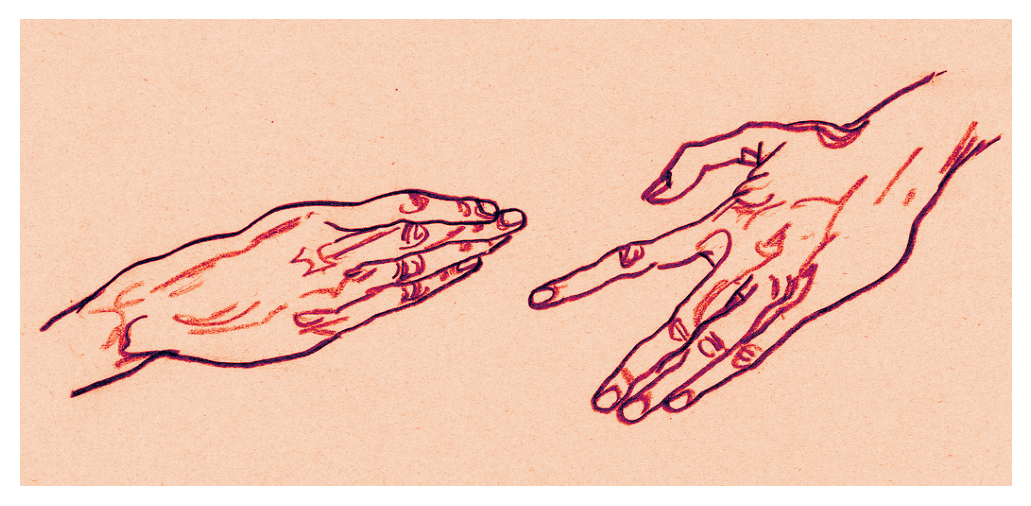

In [7]:

img=skimage.color.rgb2gray(skimage.io.imread('schieleTest.jpg'))
fig, ax=plt.subplots()
ax.imshow(img)
ax.axis('off')

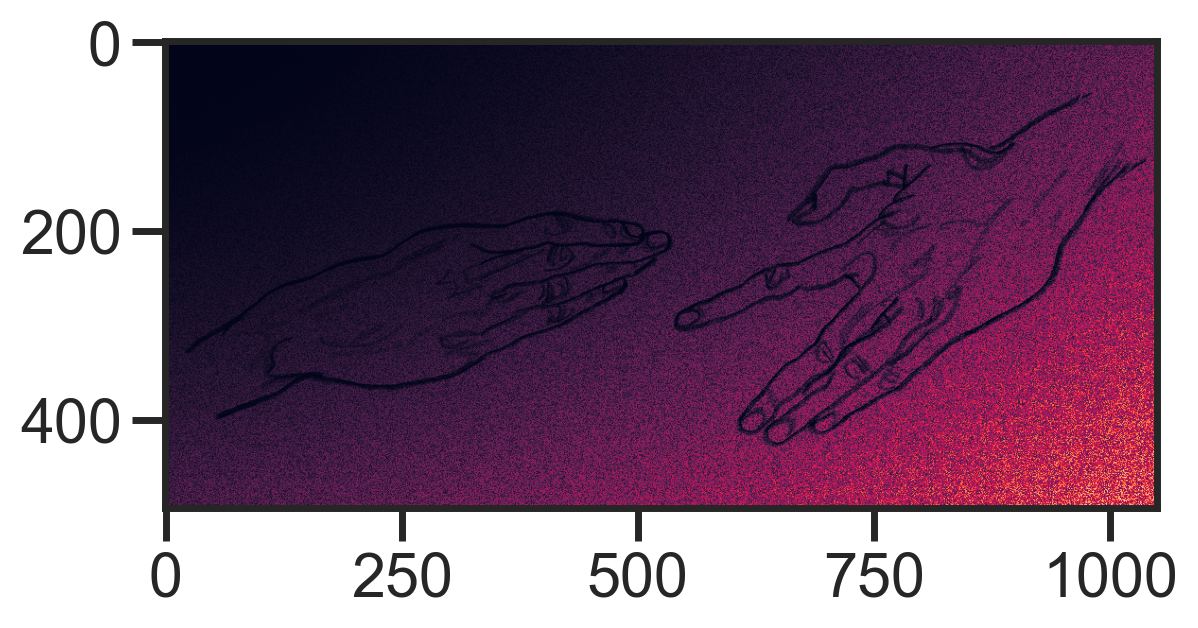

In [9]:
img=img;
# generate a uniform field of uniformly-random noise, and multiply
rndm=np.reshape(np.random.uniform(0.2,1,img.shape[0]*img.shape[1]), img.shape)
new=np.multiply(img, rndm)

## simulate
# Generate random coefficients for the polynomial
np.random.seed(1)  # For reproducibility
a00 = np.random.rand()
a10 = np.random.rand()
a01 = np.random.rand()
a20 = np.random.rand()
a11 = np.random.rand()
a02 = np.random.rand()

# Create a meshgrid of the row (i) and column (j) indices
i = np.arange(img.shape[0])
j = np.arange(img.shape[1])
I, J = np.meshgrid(i, j, indexing='ij')
# Compute the polynomial values
illumination_pattern = (a00 + a10 * I + a01 * J +
                        a20 * I**2 + a11 * I * J + a02 * J**2)
# Normalize the illumination pattern to the range [0, 255] for visualization
illumination_pattern_normalized = 1 * (illumination_pattern - np.min(illumination_pattern)) / (np.max(illumination_pattern) - np.min(illumination_pattern))

#new=new+illumination_pattern_normalized
new=np.multiply(new,illumination_pattern_normalized)
plt.imshow(new)

In [10]:
import tifffile as tiff
# Save numpy array to a TIFF file
tiff.imwrite('noised_nonhom_schiele.tif', new)

## Fitting

In [11]:
# optionally, read in the noised image directly
new=skimage.io.imread('noised_nonhom_schiele.tif')

In [12]:
def fit_bivariate_quadratic(image):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    image (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Get image dimensions
    M, N = image.shape

    # Create a meshgrid of coordinates
    i = np.arange(M)
    j = np.arange(N)
    I, J = np.meshgrid(i, j, indexing='ij')

    # Flatten the matrices for the least squares fitting
    I_flat = I.flatten()
    J_flat = J.flatten()
    Z_flat = image.flatten()

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly(image):
    """ Evaluates best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic(image);
    I, J = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing='ij')
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted

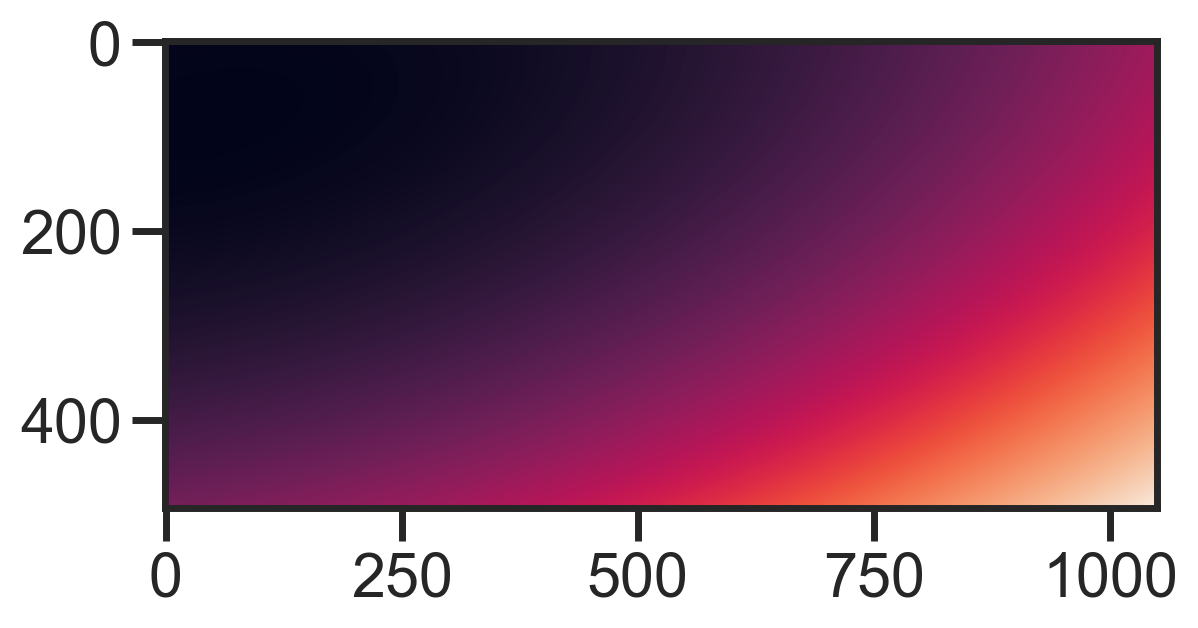

In [13]:
plt.imshow(evaluateBivPoly(new))

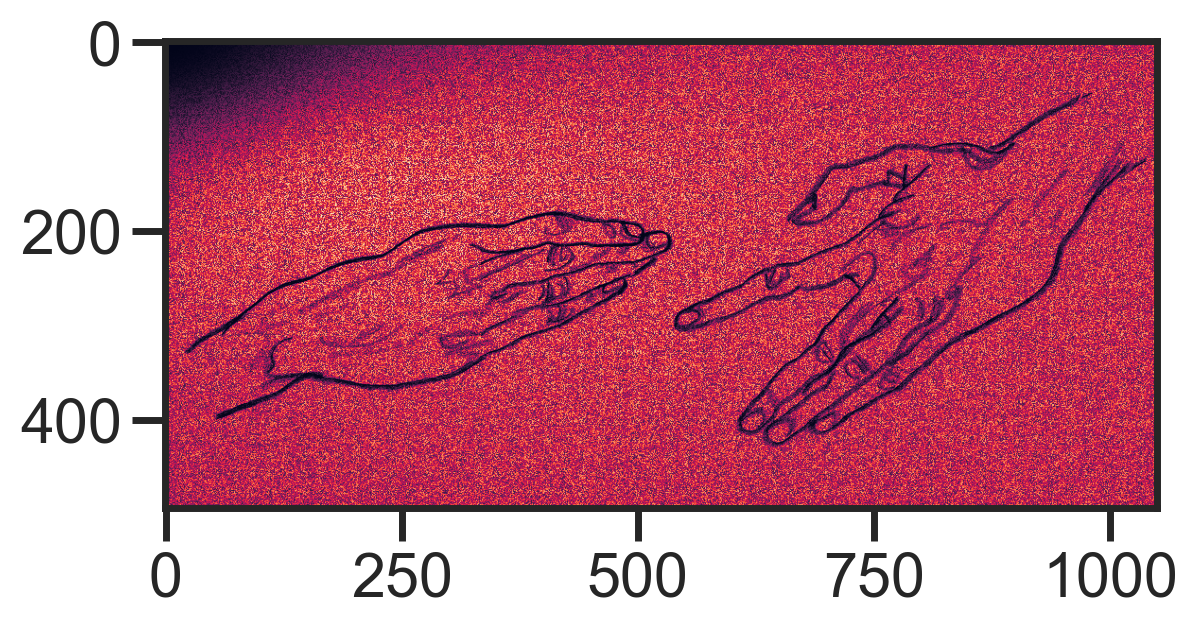

In [14]:
plt.imshow(new/evaluateBivPoly(new))